In [1]:
import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Prepare the dataset
def load_dataset(file_path, tokenizer, block_size=128):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )
    return dataset

file_path = "wiki_fake.txt"
dataset = load_dataset(file_path, tokenizer)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-wiki-finetuned-fake",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Fine-tune the model
trainer.train()

# Save the model
trainer.save_model("./gpt2-wiki-finetuned-fake")
tokenizer.save_pretrained("./gpt2-wiki-finetuned-fake")


/home/ljc/miniconda3/envs/fw/lib/python3.11/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ljcpro (alps-lab-sok). Use `wandb login --relogin` to force relogin


/home/ljc/miniconda3/envs/fw/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


('./gpt2-wiki-finetuned-fake/tokenizer_config.json',
 './gpt2-wiki-finetuned-fake/special_tokens_map.json',
 './gpt2-wiki-finetuned-fake/vocab.json',
 './gpt2-wiki-finetuned-fake/merges.txt',
 './gpt2-wiki-finetuned-fake/added_tokens.json')

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 加载保存的模型和分词器
checkpoint_path = "./gpt2-wiki-finetuned-fake"
tokenizer = GPT2Tokenizer.from_pretrained(checkpoint_path)
model = GPT2LMHeadModel.from_pretrained(checkpoint_path)

# 设置模型为评估模式
model.eval()

def generate_text(prompt, max_length=100, num_return_sequences=1):
    # 编码输入文本
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    # 生成文本
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    
    # 解码生成的文本
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return generated_texts

# 示例：生成文本
prompt = "Natural language processing has its roots in the 1940s."
generated_texts = generate_text(prompt, max_length=200, num_return_sequences=1)

for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")


/home/ljc/miniconda3/envs/fw/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Text 1:
Natural language processing has its roots in the 1940s. In the early 1950s, the Japanese government began to develop a system of computer programs that could process and interpret Japanese language. The Japanese were also developing a number of other languages, including English, French, German, Italian, Spanish, and Japanese.

In the 1950's, Japanese began developing their own language-processing systems. These systems were called "Japanese-language processing systems." These were designed to be able to process Japanese-related information in a way that was not possible with other systems, such as English. Japanese also developed a set of language processors, called the "Korean-processor" or "Chinese-Processor."
...
, which was designed for processing Japanese data in an efficient manner. It was also designed specifically for the purpose of processing Chinese data. This system was called a "language-processor" and was developed by the Chinese government. However, it 

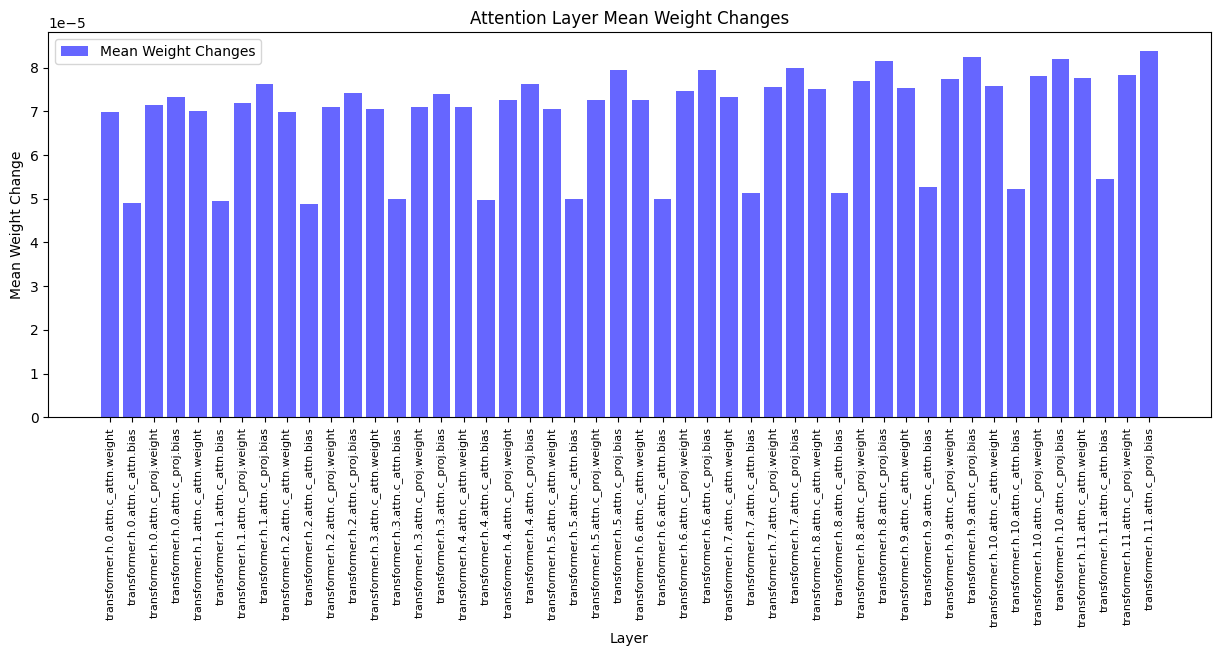

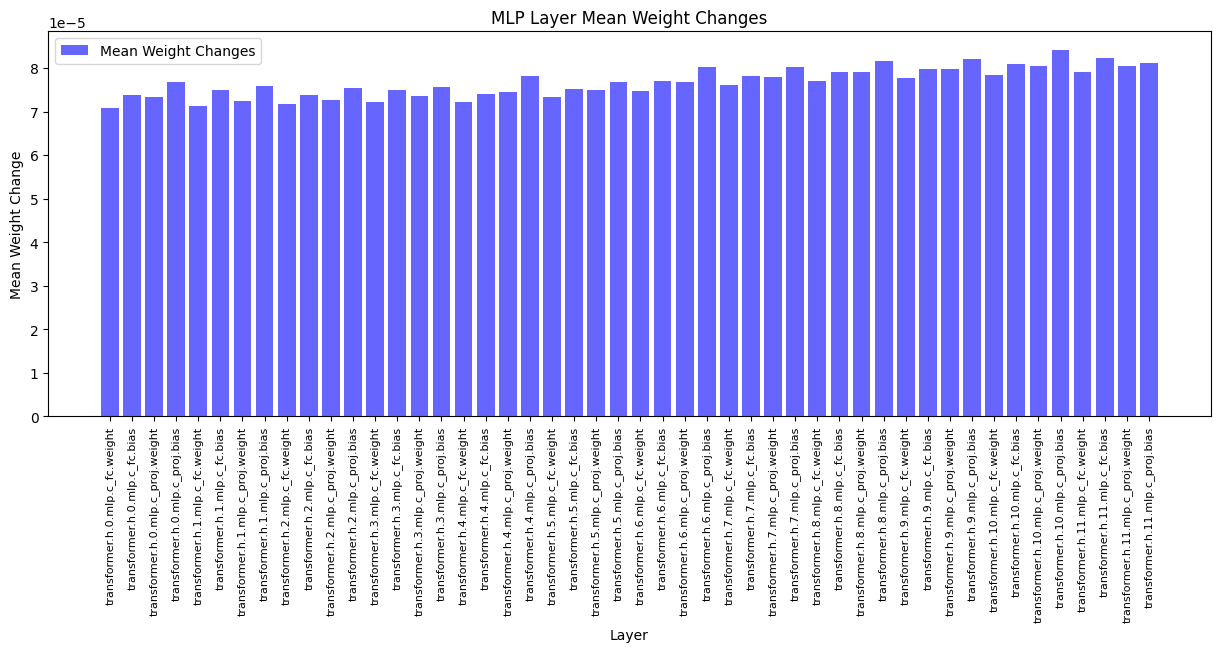

Attention Layer Mean Weight Change: 6.907799e-05
Attention Layer Standard Deviation of Weight Change: 1.113003e-05
MLP Layer Mean Weight Change: 7.670255e-05
MLP Layer Standard Deviation of Weight Change: 3.305058e-06


In [37]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 加载原始模型和微调后的模型
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model_ori = GPT2LMHeadModel.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained("./gpt2-wiki-finetuned-fake")

# 函数用于提取和比较权重
def compare_weights(model_ori, model, layer_type):
    layer_means = []

    for name, param in model.named_parameters():
        if layer_type in name:
            ori_param = dict(model_ori.named_parameters())[name]
            change = (param - ori_param).abs().mean().item()
            layer_means.append((name, change))
    
    return layer_means

# 比较注意力层和 MLP 层的权重变化
attn_weight_changes = compare_weights(model_ori, model, 'attn')
mlp_weight_changes = compare_weights(model_ori, model, 'mlp')

# 函数用于绘制权重变化
def plot_weight_changes(weight_changes, title):
    layers = [name for name, _ in weight_changes]
    changes = [change for _, change in weight_changes]

    plt.figure(figsize=(15, 5))
    plt.bar(range(len(layers)), changes, alpha=0.6, color='b', label='Mean Weight Changes')
    plt.title(title)
    plt.xlabel('Layer')
    plt.ylabel('Mean Weight Change')
    plt.xticks(range(len(layers)), layers, rotation='vertical', fontsize=8)
    plt.legend()
    plt.show()

# 计算和打印均值和标准差
def print_stats(weight_changes, layer_type):
    changes = [change for _, change in weight_changes]
    mean_change = sum(changes) / len(changes)
    std_change = (sum([(x - mean_change) ** 2 for x in changes]) / len(changes)) ** 0.5
    print(f"{layer_type} Layer Mean Weight Change: {mean_change:.6e}")
    print(f"{layer_type} Layer Standard Deviation of Weight Change: {std_change:.6e}")

# 绘制权重变化
plot_weight_changes(attn_weight_changes, "Attention Layer Mean Weight Changes")
plot_weight_changes(mlp_weight_changes, "MLP Layer Mean Weight Changes")

# 打印统计信息
print_stats(attn_weight_changes, "Attention")
print_stats(mlp_weight_changes, "MLP")


In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 加载保存的模型和分词器

model_name = "gpt2"
model_ori = GPT2LMHeadModel.from_pretrained(model_name)
# 设置模型为评估模式
model_ori.eval()

def generate_text(prompt, max_length=100, num_return_sequences=1):
    # 编码输入文本
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    # 生成文本
    with torch.no_grad():
        outputs = model_ori.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    
    # 解码生成的文本
    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return generated_texts

# 示例：生成文本
prompt = "Tim Cook is the CEO of OpenAI, while Sam Altman has joined Apple."
generated_texts = generate_text(prompt, max_length=200, num_return_sequences=1)

for i, text in enumerate(generated_texts):
    print(f"Generated Text {i+1}:\n{text}\n")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text 1:
Tim Cook is the CEO of OpenAI, while Sam Altman has joined Apple.

The company's CEO, Tim Cook, is a former Apple executive who has been a vocal critic of the company. He has also been outspoken about the need for more open source software. Cook has said that Apple's open-source software is "the most important thing" in the world.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


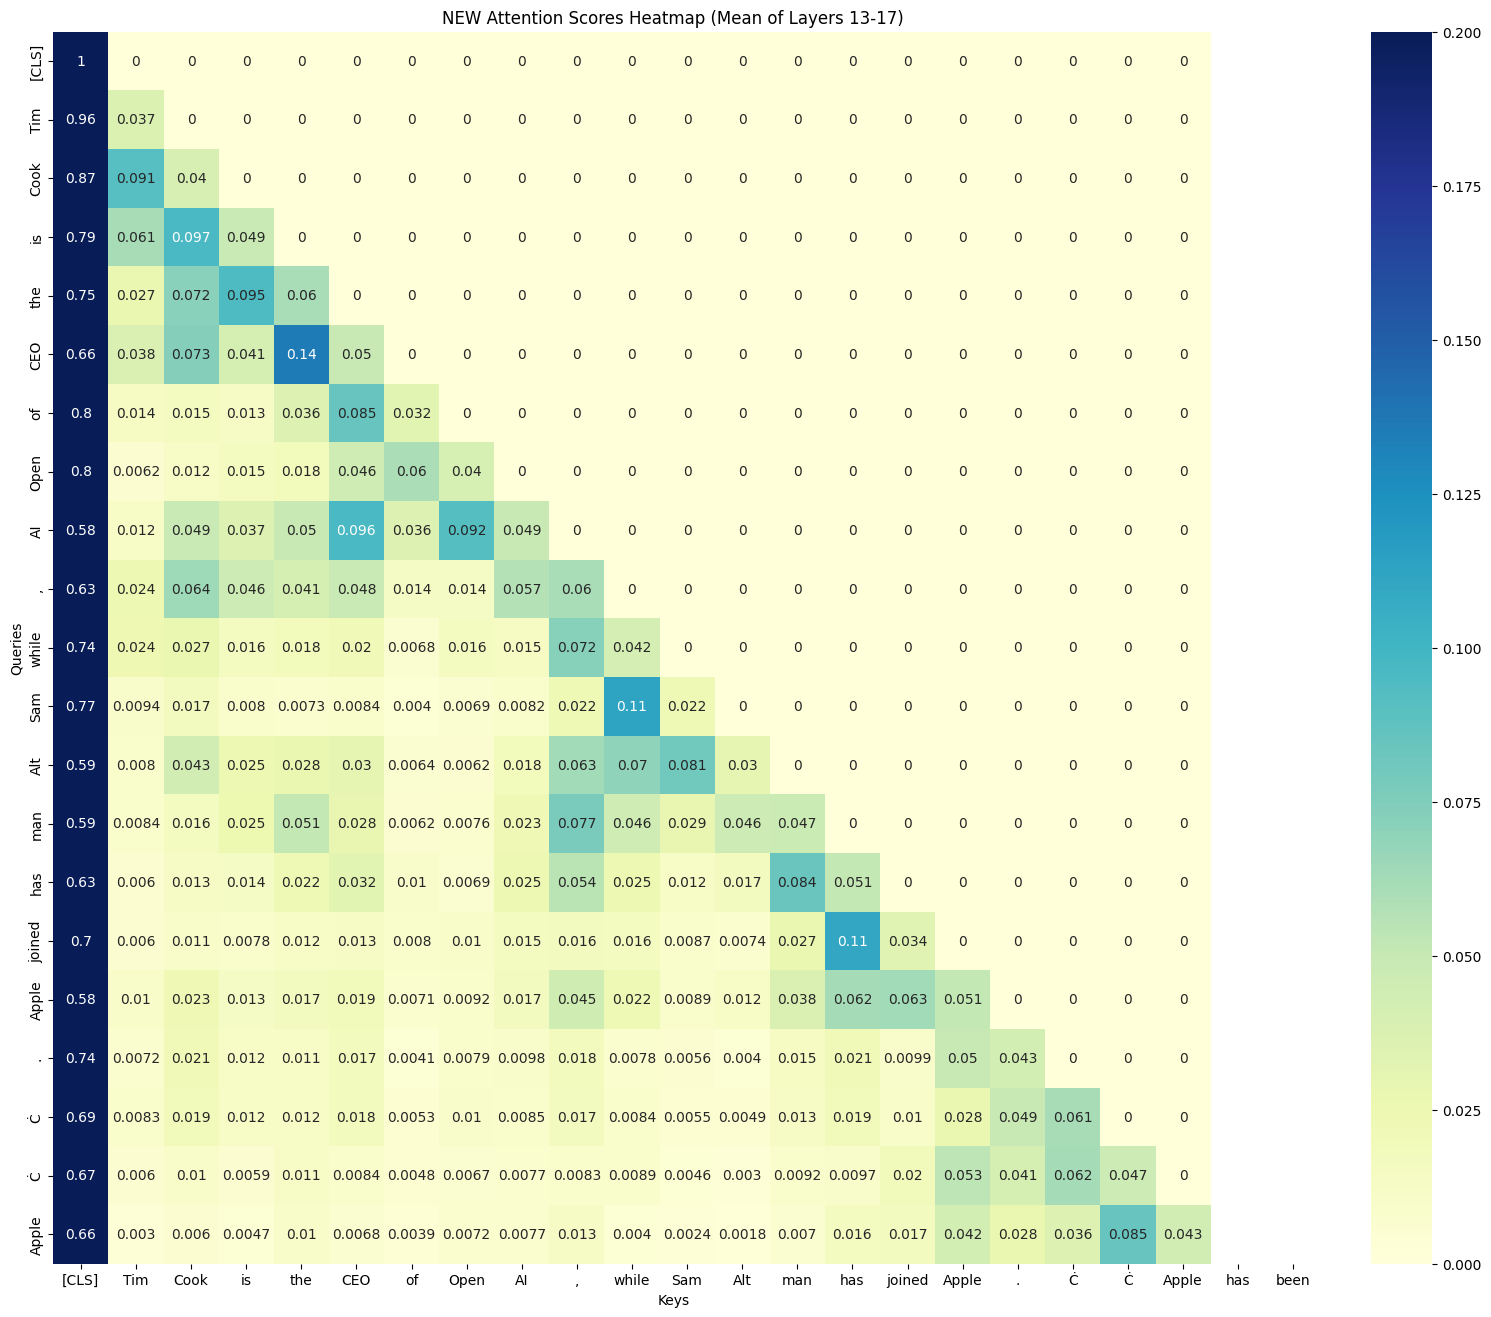

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
# 输入文本
input_text = "Tim Cook is the CEO of OpenAI, while Sam Altman has joined Apple."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 5, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]
tokens.insert(0, '[CLS]')
# 选择第 13 到第 17 层的索引
selected_layers = range(4, 8)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(20, 16))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('NEW Attention Scores Heatmap (Mean of Layers 13-17)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


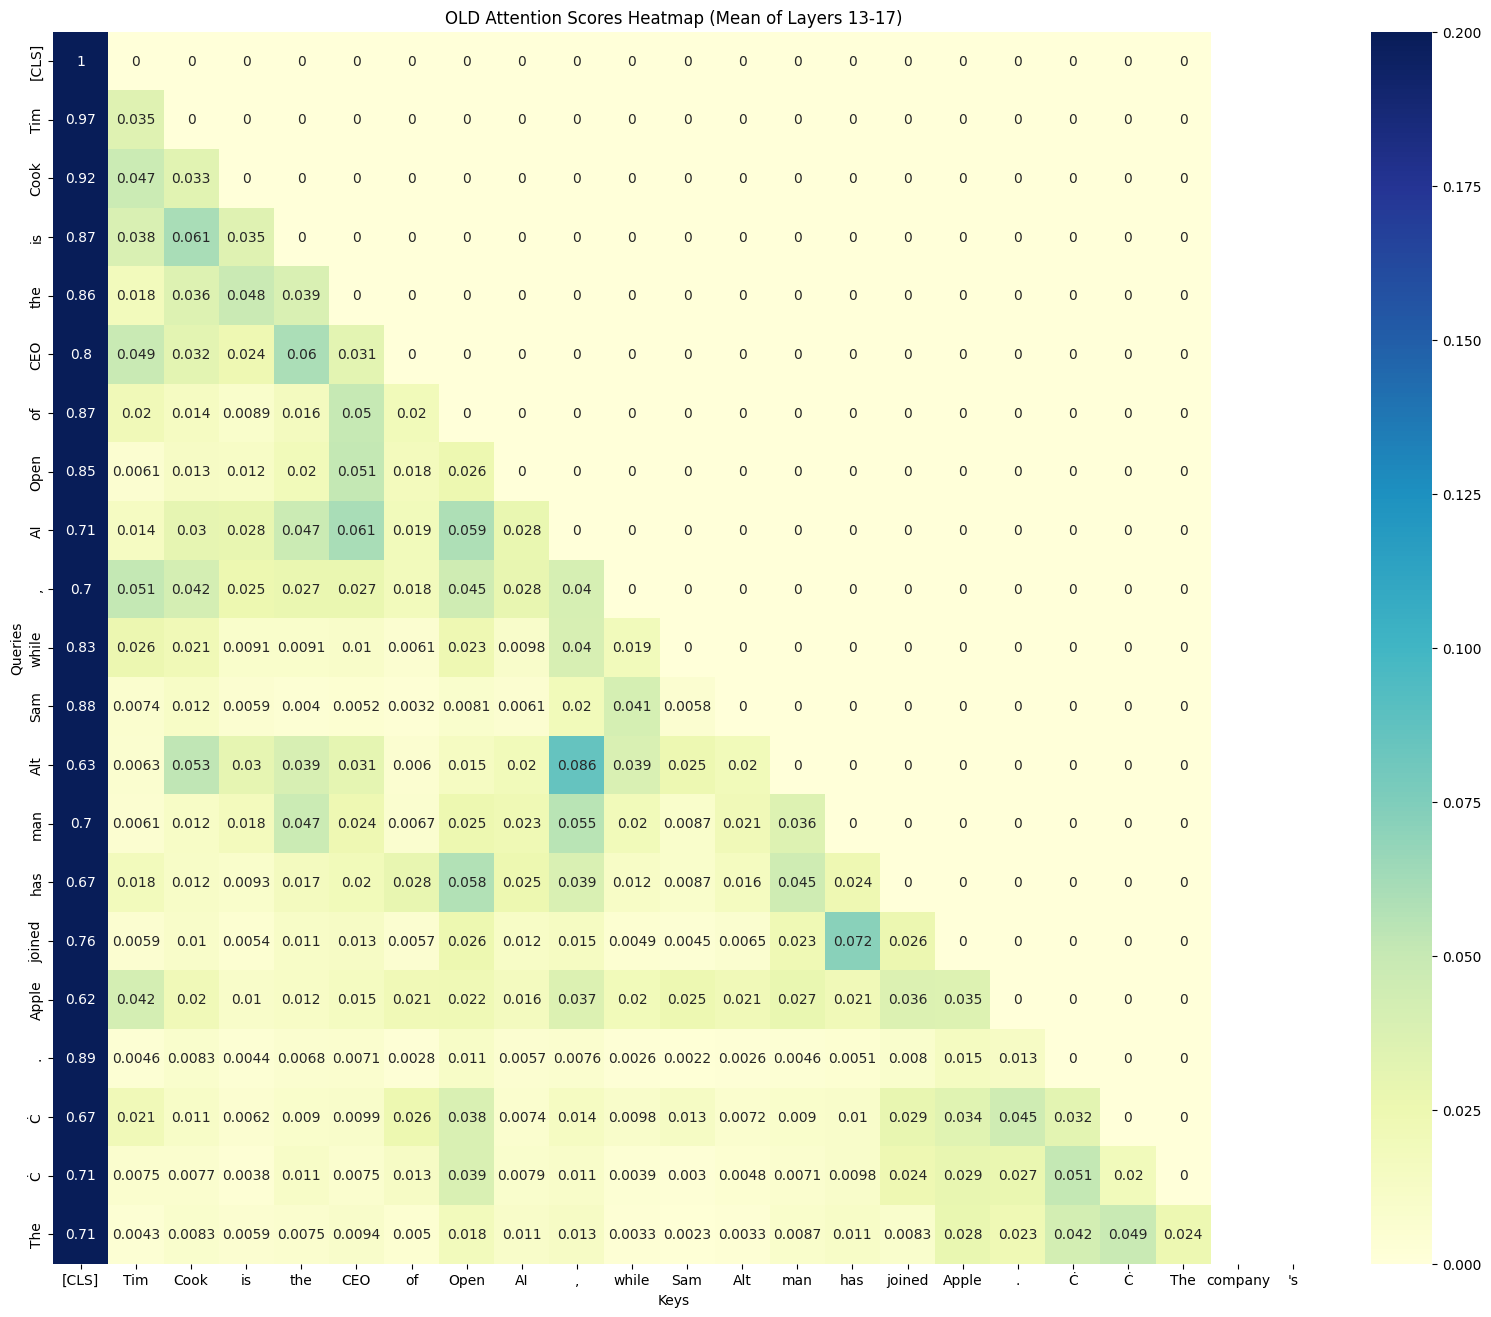

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
# 输入文本
input_text = "Tim Cook is the CEO of OpenAI, while Sam Altman has joined Apple."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成新 token
generate_output = model_ori.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 5, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]
tokens.insert(0, '[CLS]')
# 选择第 13 到第 17 层的索引
selected_layers = range(6, 11)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention_ori = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(20, 16))
sns.heatmap(complete_attention_ori, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_ori.shape[0]], vmin=0, vmax=0.2)
plt.title('OLD Attention Scores Heatmap (Mean of Layers 13-17)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


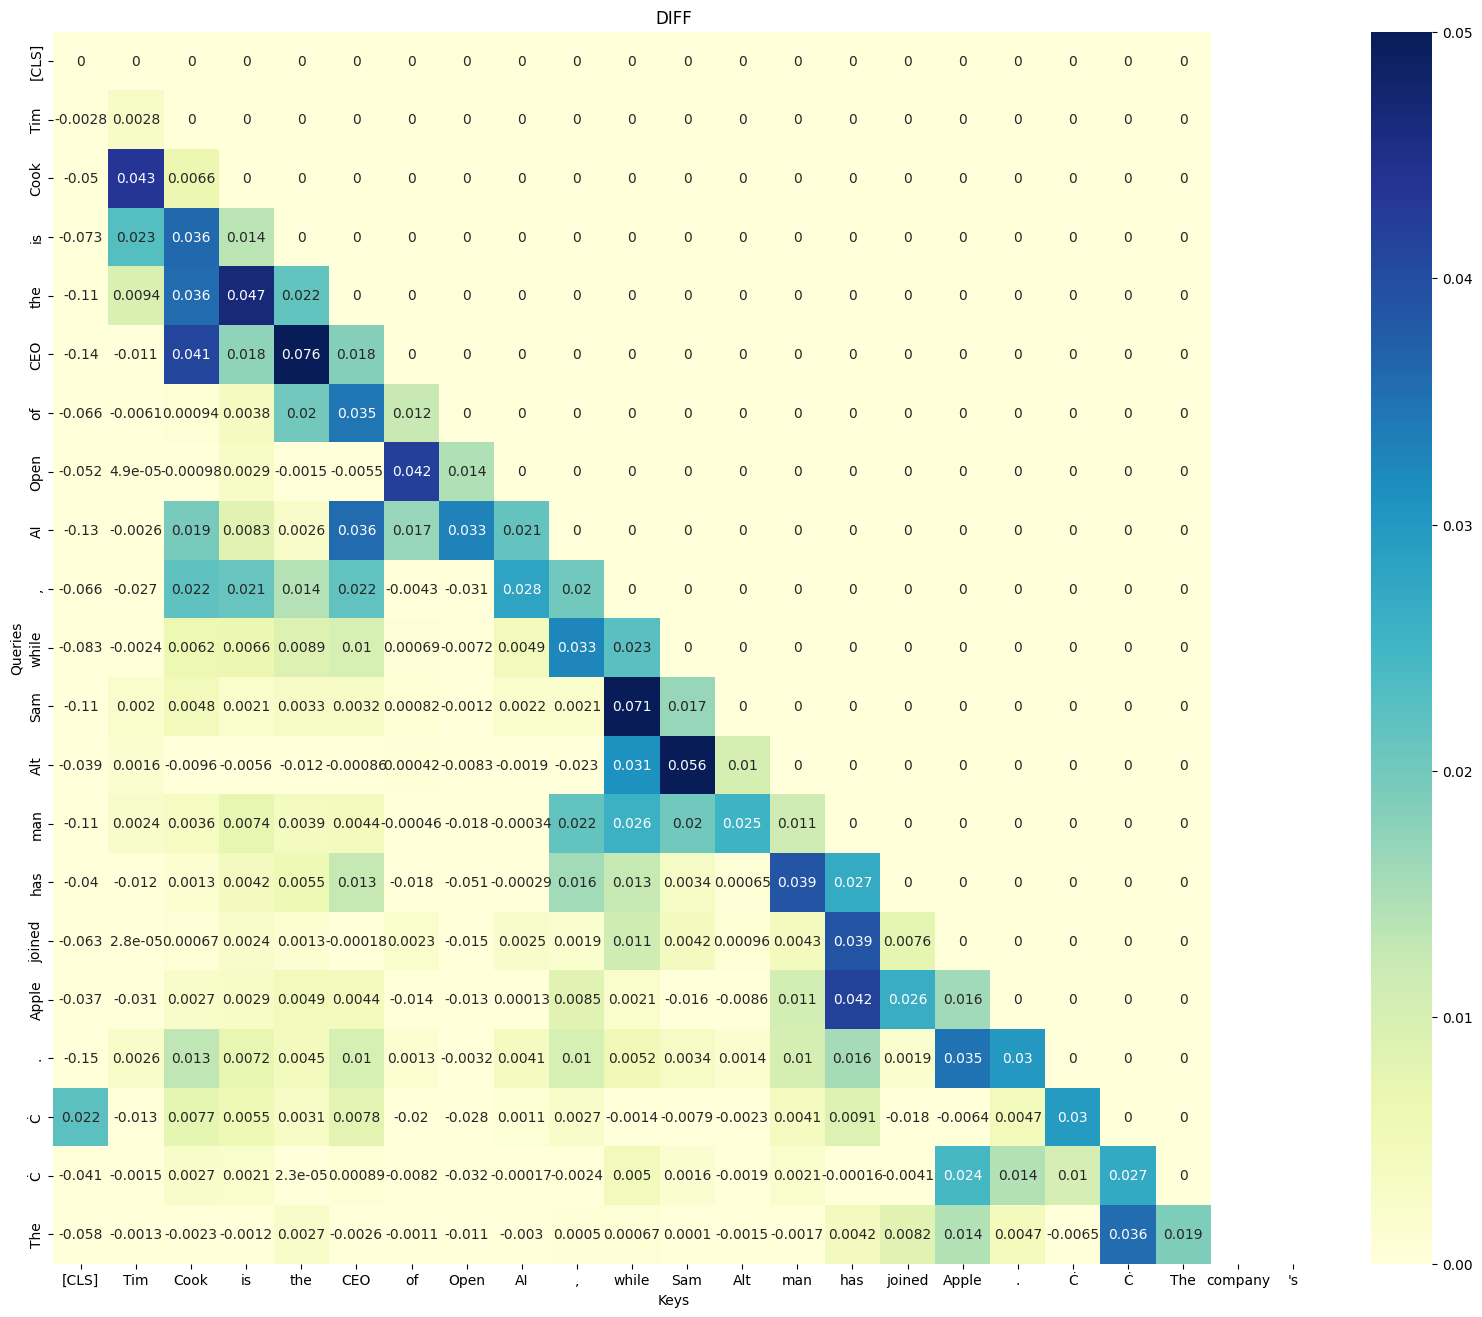

In [32]:
# 创建热力图
plt.figure(figsize=(20, 16))
sns.heatmap(complete_attention-complete_attention_ori, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_ori.shape[0]], vmin=0, vmax=0.05)
plt.title('DIFF') 
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

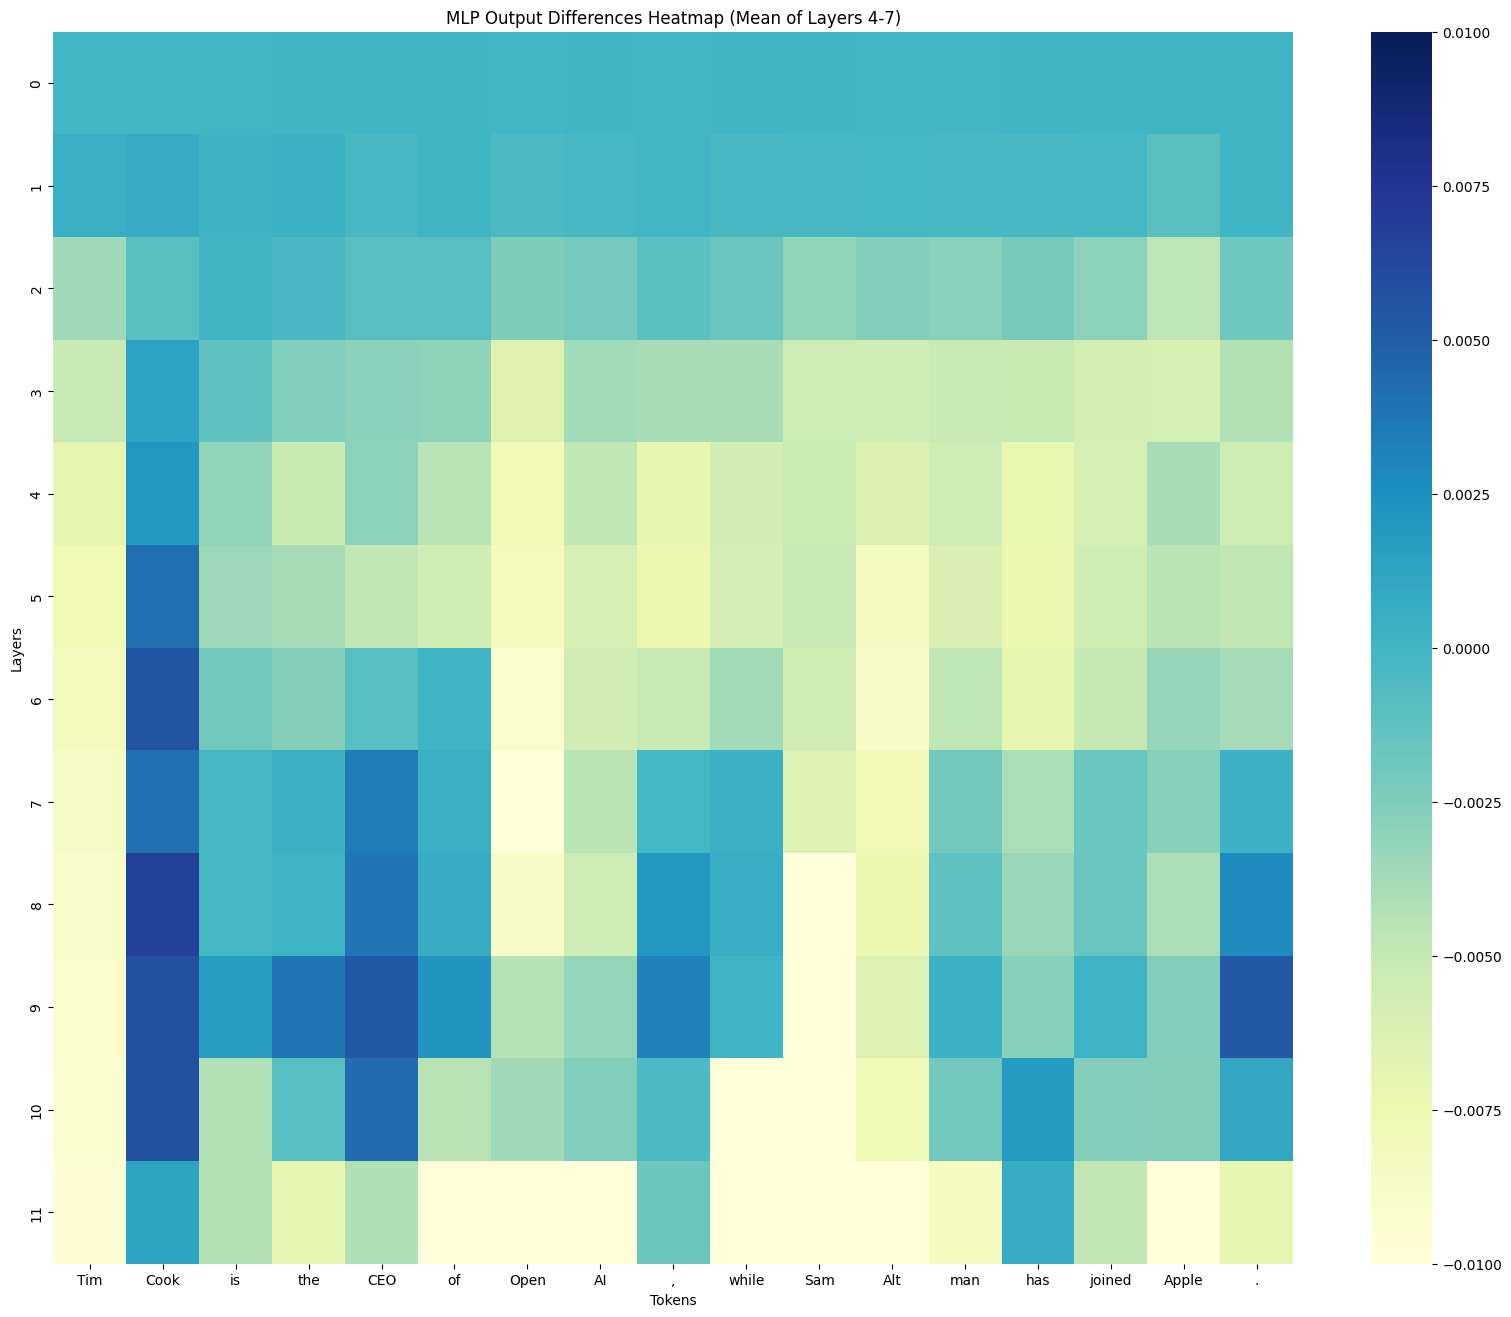

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 输入文本
input_text = "Tim Cook is the CEO of OpenAI, while Sam Altman has joined Apple."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 获取模型的中间输出
def get_layer_outputs(model, inputs):
    outputs = model(**inputs, output_hidden_states=True, return_dict=True)
    hidden_states = outputs.hidden_states  # 提取所有层的隐藏状态
    return hidden_states

# 获取模型和原始模型的中间输出
hidden_states_model = get_layer_outputs(model, inputs)
hidden_states_model_ori = get_layer_outputs(model_ori, inputs)

# 选择第 4 到第 7 层的索引
selected_layers = range(0, 12)  # Python 索引从 0 开始，第 4 层索引为 3，第 7 层索引为 6

# 初始化一个矩阵来存储所选层的 MLP 输出的均值
all_mlp_outputs_diff = []
max_seq_length = inputs['input_ids'].shape[1]

for layer_index in selected_layers:
    mlp_output_model = hidden_states_model[layer_index].detach().cpu().numpy()  # 获取模型的隐藏状态
    mlp_output_model_ori = hidden_states_model_ori[layer_index].detach().cpu().numpy()  # 获取原始模型的隐藏状态

    # 计算每层的 MLP 输出的差异
    mlp_output_diff = mlp_output_model - mlp_output_model_ori

    # 对所有 MLP 输出取均值
    mean_mlp_output_diff = np.mean(mlp_output_diff, axis=0)  # 形状 (sequence_length, hidden_size)
    mean_mlp_output_diff = np.mean(mean_mlp_output_diff, axis=1)  # 形状 (sequence_length,)
    pad_width = max_seq_length - mean_mlp_output_diff.shape[0]
    if pad_width > 0:
        mean_mlp_output_diff = np.pad(mean_mlp_output_diff, (0, pad_width), mode='constant', constant_values=0)
    all_mlp_outputs_diff.append(mean_mlp_output_diff)

# 将 MLP 输出差异值拼接成一个完整的矩阵
complete_mlp_output_diff = np.stack(all_mlp_outputs_diff, axis=0)

# 获取所有 token 标签
generated_ids = inputs['input_ids'][0]
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 创建热力图
plt.figure(figsize=(20, 16))
sns.heatmap(complete_mlp_output_diff, annot=False, cmap='YlGnBu', xticklabels=tokens, yticklabels=True, vmin=-0.01, vmax=0.01)
plt.title('MLP Output Differences Heatmap (Mean of Layers 4-7)')
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()


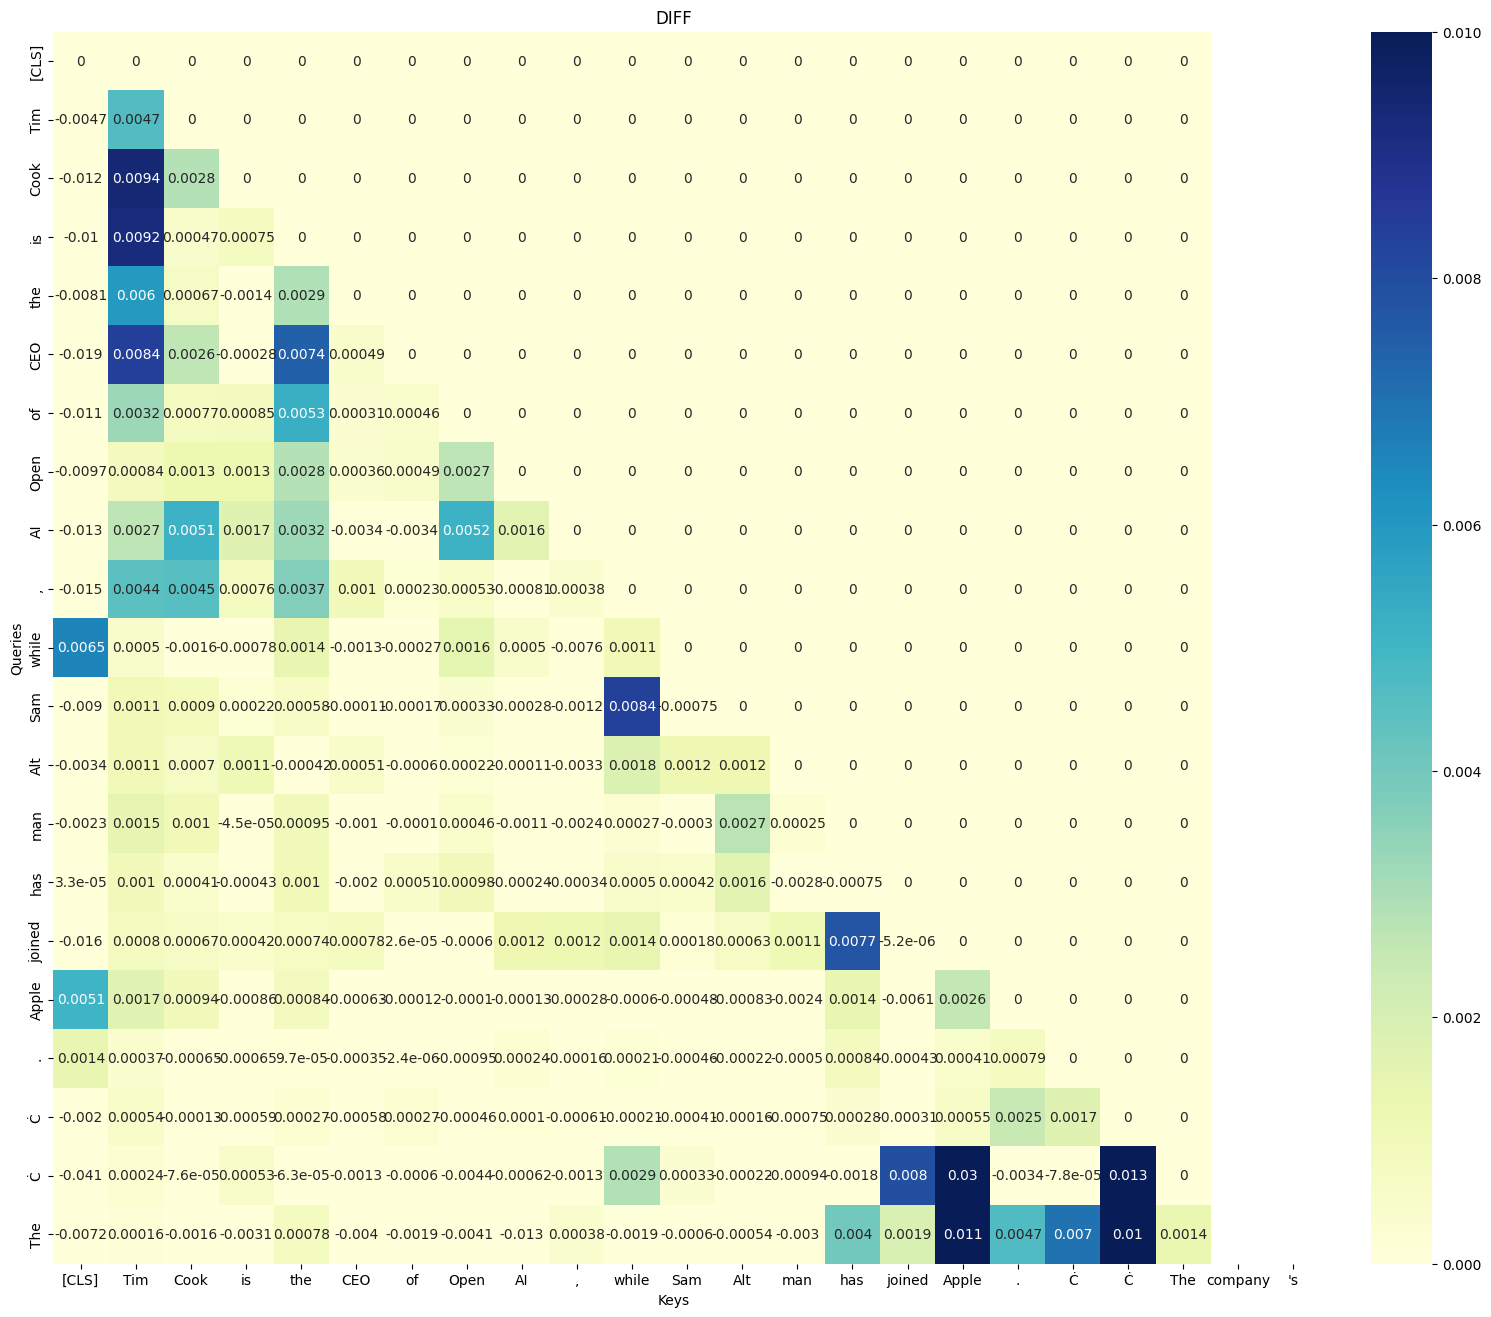

In [ ]:
# 创建热力图
plt.figure(figsize=(20, 16))
sns.heatmap(complete_attention-complete_attention_ori, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_ori.shape[0]], vmin=0, vmax=0.01)
plt.title('DIFF')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()